In [ ]:
# CNN

In [1]:
# IMPORTS
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, Input
from tensorflow.keras import backend as K
from tensorflow.keras import regularizers
from tensorflow.keras.utils import Sequence
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint
from collections import namedtuple
import math
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import datetime, time
import os, sys
import tqdm
import gc
from multiprocessing import Process
Point = namedtuple('Point', ('x', 'y'))
Circle = namedtuple('Circle', ('r'))
Square = namedtuple('Square', ('side'))
Rectangle = namedtuple('Rectangle', ('length', 'width'))
PointWithDistance = namedtuple('PointWithDistance', ('p', 'dist'))
float_memory_used = 'float16'

In [2]:
# INIT
# PART 1
# number_samples = [5] + list(range(10, 101, 10)) + [120, 150, 200, 250, 300, 400, 500, 700] + list(range(1000, 10001, 1000))
number_samples = [256, 512, 1024, 2048, 4096, 8192] 
# number_samples = [4096, 4915, 5734, 6554, 7373, 8192]

# cnn_type = "classification"  # {"classification", "regression"}
max_power_value = 0.0
validation_size, noise_floor = 0.33, -110.0  # -90.0
su_power = 0 # this is not actually su power just a number to show there is an SU in its image
max_x, max_y, su_szie = 100, 100, 10
number_image_channels = math.ceil(abs(max_power_value - noise_floor)/5) # 5 is power range for each channel
number_image_channels = 8
pu_shape, su_shape = 'circle', 'circle' # shape = {'circle', 'square', 'point'}
style = "raw_power_min_max_norm"  # {"raw_power_zscore_norm", "image_intensity", "raw_power_min_max_norm"}
intensity_degradation, slope = 'log', 5  # 'log', 'linear'
max_pus_num, max_sus_num = 20, 1
propagation_model = 'splat' # 'splat', 'log', 'testbed'
noise, std = False, 1
if su_shape == 'circle':
    su_param = Circle(su_szie)
elif su_shape == 'square':
    su_param = Square(su_szie)
else:
    su_param = None
    
sensors_num = 3600
sensors_file_path = "../../../java_workspace/research/commons/resources/sensors/square" \
    + str(max(max_x, max_y)) + "/" + str(sensors_num) + "/sensors.txt"
# num_pus = (data_reg.shape[1] - 3)//3

# PART 2
number_of_proccessors = 10
memory_size_allowed = 4 # in Gigabyte
float_size = 0
if float_memory_used == "float16":
    float_size = 16
elif float_memory_used == "float" or "float32":
    float_size = 32
elif float_memory_used == "float8":
    float_size = 8


batch_size = int(memory_size_allowed / (max_x * max_y * number_image_channels * float_size/(8 * 1024 ** 3)))


dtime = datetime.datetime.now().strftime('_%Y%m_%d%H_%M')
color = "color" if number_image_channels > 1 else "gray"
image_dir = 'ML/data/pictures_' + str(max_x) + '_' + str(max_y) + '/' + propagation_model + (
    "/noisy_std_" + str(std) if noise else "") + '/pu_' + pu_shape + '_su_' + su_shape + '_' + (
    "" if su_shape == 'point' else str(su_szie)) + "/" + style + "/" + color +'/' + (
    "" if pu_shape == 'point' and su_shape == 'point' else (intensity_degradation + '_' + str(slope))) + (
    "/" + str(sensors_num) + "sensors_pus") + "/images"

if not os.path.exists(image_dir):
        os.makedirs(image_dir)

In [3]:
image_dir

'ML/data/pictures_100_100/splat/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/3600sensors_pus/images'

In [4]:
# LOAD DATA
pu_num_columns = max_pus_num * 3 + 1 + max_sus_num * 3 + 2
sensor_columns = sensors_num + max_sus_num * 3 + 2
pu_cols = [i for i in range(pu_num_columns)]
sensor_cols = [i for i in range(sensor_columns)]
pu_dataset_name = "dynamic_pus_using_pus_60000_min10_max20PUs_1SUs_square100grid_splat_2020_06_29_19_50.txt"
sensor_dataset_name = "dynamic_pus_3600sensor_60000_min10_max20PUs_1SUs_square100grid_splat_2020_06_29_19_50.txt"
max_dataset_name = "dynamic_pus_max_power_60000_min10_max20PUs_1SUs_square100grid_splat_2020_06_29_19_50.txt"
with open('/'.join(image_dir.split('/')[:-1]) + '/datasets' + dtime + '.txt', 'w') as set_file:
    set_file.write(pu_dataset_name + "\n")
    set_file.write(sensor_dataset_name + "\n")
    set_file.write(max_dataset_name)

pu_dataframe = pd.read_csv('../../../java_workspace/research/spectrum_allocation/resources/data/'
                        + pu_dataset_name, delimiter=',', header=None, names=pu_cols)
sensor_dataframe = pd.read_csv('../../../java_workspace/research/spectrum_allocation/resources/data/'
                        + sensor_dataset_name, delimiter=',', header=None, names=sensor_cols)
dataframe_max = pd.read_csv('../../../java_workspace/research/spectrum_allocation/resources/data/'
                            + max_dataset_name, delimiter=',', header=None)

pu_dataframe.reset_index(drop=True, inplace=True)
sensor_dataframe.reset_index(drop=True, inplace=True)
dataframe_max.reset_index(drop=True, inplace=True)

pu_dataframe_tot = pd.concat([pu_dataframe, 
                              dataframe_max.iloc[:, dataframe_max.columns.values[-1:]]],
                             axis=1,ignore_index=True)
sensor_dataframe_tot = pd.concat([sensor_dataframe,
                                  dataframe_max.iloc[:, dataframe_max.columns.values[-1:]]],
                                 axis=1, ignore_index=True)

idx = pu_dataframe_tot[pu_dataframe_tot[pu_dataframe_tot.columns[-1]] == -float('inf')].index
pu_dataframe_tot.drop(idx, inplace=True)
sensor_dataframe_tot.drop(idx, inplace=True)

pu_data_reg = pu_dataframe_tot.values
sensor_data_reg = sensor_dataframe_tot.values
sensor_data_reg[sensor_data_reg < noise_floor] = noise_floor
# data_reg = np.concatenate((dataframe_tot.values[:, 0:dataframe_tot.shape[1]-3], 
#                            dataframe_tot.values[:, dataframe_tot.shape[1]-1:dataframe_tot.shape[1]]), axis=1)
# data_class = dataframe_tot.values[:, 0:dataframe_tot.shape[1]-1]
# y_class_power = dataframe_tot.values[:, -1]
sensors_location = []
with open(sensors_file_path, 'r') as f:
    lines = f.readlines()
    for line in lines:
        line = line.split(',')
        sensors_location.append(Point(int(float(line[0])), int(float(line[1]))))
del dataframe_max, pu_dataframe, pu_dataframe_tot, sensor_dataframe, sensor_dataframe_tot

In [5]:
print(pu_data_reg.shape)
print(sensor_data_reg.shape)

(39539, 67)
(39539, 3606)


In [ ]:
data_reg = np.concatenate((data_reg[:,:2500], np.ones((4000, 1)), data_reg[:, 2500:2504],
               data_reg[:, 2505:]), axis=1)

In [6]:
pu_data_reg = pu_data_reg[:][:30000]
sensor_data_reg = sensor_data_reg[:][:30000]

In [24]:
data_reg[512:1024, :] = data_reg[:512, :]

In [ ]:
data_reg[4096:8192, sensors_num:] = data_reg[:4096, sensors_num:]

In [11]:
print(data_reg[10, :])
print(data_reg[266, :])

[ 10.     62.     30.    -19.362  71.     26.    -23.844  24.     53.
  -7.168  90.     75.     -8.733  34.     13.    -23.463  12.      9.
  -7.096   4.     22.    -12.819  66.     65.    -10.794   7.     20.
  -7.626   4.     36.    -28.694   1.     56.     17.    -16.531   1.
     nan     nan     nan     nan     nan     nan     nan     nan     nan
     nan     nan     nan     nan     nan     nan     nan     nan     nan
     nan     nan     nan     nan     nan     nan     nan     nan     nan
     nan     nan     nan   2.312]
[ 10.     62.     30.    -19.362  71.     26.    -23.844  24.     53.
  -7.168  90.     75.     -8.733  34.     13.    -23.463  12.      9.
  -7.096   4.     22.    -12.819  66.     65.    -10.794   7.     20.
  -7.626   4.     36.    -28.694   1.     56.     17.    -16.531   1.
     nan     nan     nan     nan     nan     nan     nan     nan     nan
     nan     nan     nan     nan     nan     nan     nan     nan     nan
     nan     nan     nan     nan     nan 

In [7]:
def euclidian_distance(p1: Point, p2: Point):
    return ((p1.x - p2.x) ** 2 + (p1.y - p2.y) ** 2) ** 0.5

def calculate_mu_sigma(data, num_pus):
    sum_non_noise = 0
    for pu_n in range(num_pus): # calculate mu
        sum_non_noise += data[pu_n*3+2]
    mu = ((max_x * max_y - num_pus) * noise_floor + sum_non_noise)/(max_x * max_y)
    sum_square = 0
    for pu_n in range(num_pus): # calculate sigma
        sum_square += (data[pu_n*3+2]-mu)**2
    sum_square += (max_x * max_y - num_pus) * (noise_floor - mu)**2
    sigma = math.sqrt(sum_square/(max_x * max_y))
    return mu, sigma

def get_pu_param(pu_shape: str, intensity_degradation: str, pu_p: float, noise_floor: float, slope: float):
    pu_param = None
    if pu_shape == 'circle':
        if intensity_degradation == "linear":
            pu_param = Circle(int((pu_p - noise_floor) / slope)) # linear
        elif intensity_degradation == "log":
            pu_param = Circle(int(10 ** ((pu_p - noise_floor) / (10 *slope)))) # log_based
    elif pu_shape == 'square':
        if intensity_degradation == "linear":
            pu_param = Square(int(2 ** 0.5 * (pu_p - noise_floor) / slope)) # linear
        elif intensity_degradation == "log":
            pu_param = Square(int(2 ** 0.5 * 10 ** ((pu_p - noise_floor) / (10 *slope)))) # log_based
    elif pu_shape == 'point':
        pu_param = None
    else:
        raise ValueError("Unsupported PU shape(create_image)! ", pu_shape)
    return pu_param

def create_image(pu_data, sensor_data, slope, sensors_num, style="raw_power_z_score", noise_floor=-90,
                 pu_shape= 'circle', pu_param=None, su_shape='circle', su_param=None,
                 intensity_degradation="log", max_pu_power: float=0):  
    # style = {"raw_power_zscore_norm", "image_intensity", "raw_power_min_max_norm"}
    # intensity_degradation= {"log", "linear"}
    # if param is None, it's automatically calculated. Highest brightness(or power value) (255 or 1.) would
    # assigned to the center(PU location) and radius(side) would be calculated based on its power, slope, and noise floor.
    # If it is given, intensity(power) of pixel beside center would be calculated in the same fashin with an exception that 
    # intensity below zero(noise_floor) would be replaced by zero(noise_floor)
    if style == "raw_power_min_max_norm":
        # In this way, PUs' location are replaced with their power(dBm) and the power would fade with 
        # slope till gets noise_floor(in circle shape)
        
        # creating pu matrix
        image = np.zeros((1,number_image_channels,max_x, max_y), dtype=float_memory_used)
        if True:  # pus
            pus_num = int(pu_data[0])
#             print(pus_num)
            for pu_i in range(pus_num):
                pu_x = max(0, min(max_x-1, int(pu_data[pu_i * 3 + 1]))) 
                pu_y = max(0, min(max_x-1, int(pu_data[pu_i * 3 + 2])))
                pu_p = pu_data[pu_i * 3 + 3]
                pu_channel = int(abs(pu_p - max_pu_power))//5
#                 print(pu_x, pu_y, pu_p)
                if pu_param is None:
                    pu_param_p = get_pu_param(pu_shape, intensity_degradation, pu_p, noise_floor, slope)
                else:
                    pu_param_p = pu_param
                points = points_inside_shape(center=Point(pu_x, pu_y), shape=pu_shape, param=pu_param_p)
                for point in points:
                    if 0 <= point.p.x < max_x and 0 <= point.p.y < max_y: # TODO should pass image size
                        if intensity_degradation == "linear":
                            image[0][pu_channel][point.p.x][point.p.y] += (pu_p - slope * point.dist - noise_floor)/(
                                max_pu_power - noise_floor)
                        elif intensity_degradation == "log":
                            if point.dist < 1:
                                image[0][pu_channel][point.p.x][point.p.y] += (pu_p - noise_floor) / (max_pu_power - noise_floor)
                            else:
                                image[0][pu_channel][point.p.x][point.p.y] += (pu_p - slope * 10*math.log10(point.dist) - noise_floor)/(
                                    max_pu_power - noise_floor)
        if True:  # sensors
            ss_param, ss_shape = pu_param, pu_shape
            ss_channel_offset = 6 # number of channels for pus
            for ss_i in range(sensors_num):
                ss_x, ss_y, ss_p = max(0, min(max_x-1, int(sensors_location[ss_i].x))), max(0, min(max_x-1, int(
                    sensors_location[ss_i].y))), max(noise_floor, sensor_data[ss_i])
#                 ss_channel =  int(abs(ss_p - max_pu_power))//5
                ss_channel = 0
#                 if -62.5 <= ss_p < -50.0:
#                     ss_channel = 1
#                 elif -75.0 <= ss_p < -62.6:
#                     ss_channel = 2
#                 elif -87.5 <= ss_p < -75.0:
#                     ss_channel = 3
#                 elif -100.0 <= ss_p < -87.5:
#                     ss_channel = 4
# #                 elif -70.0 <= ss_p < -65.0:
# #                     ss_channel = 5
#                 elif ss_p < -100.0:
#                     ss_channel = 5
                ss_channel += ss_channel_offset
                if ss_param is None:
                    ss_param_p = get_pu_param(ss_shape, intensity_degradation, ss_p,
                                              noise_floor, slope)
                    ss_param_p = Circle(3)
                else:
                    ss_param_p = ss_param
                points = points_inside_shape(center=Point(ss_x, ss_y), shape=ss_shape,
                                             param=ss_param_p)
                for point in points:
                    if 0 <= point.p.x < max_x and 0 <= point.p.y < max_y: # TODO should pass image size
                        if intensity_degradation == "linear":
                            image[0][ss_channel][point.p.x][point.p.y] += (ss_p - slope * point.dist - noise_floor)/(
                                max_pu_power - noise_floor)
                        elif intensity_degradation == "log":
                            if point.dist < 1:
                                image[0][ss_channel][point.p.x][point.p.y] += (ss_p - noise_floor) / (max_pu_power - noise_floor)
                            else:
                                image[0][ss_channel][point.p.x][point.p.y] += (ss_p - slope * 10*math.log10(point.dist) - noise_floor)/(
                                    max_pu_power - noise_floor)
        del points
        # creating su matrix
        su_num_idx = pus_num * 3 + 1
        su_num = int(pu_data[su_num_idx])
#         print(su_num)
#         su_num = (len(data) - pus_num * (3 if not sensors else 1)) // 2
#         if not (len(data) - pus_num * (3 if not sensors else 1)) % 2:
#             raise ValueError("Data provided is not correct; can't get SUs' information(create_image)")
        if su_param is None:
            # if su_param is unavailable, a circle(square) with radius(side) 1 is created
            if su_shape == 'circle':
                su_param = Circle(1)
            elif su_shape == 'square':
                su_param = Square(1)
            elif su_shape == 'point':
                su_param = None
            else:
                raise ValueError("Unsupported SU shape(create_image)! ", su_shape)
        
        for su_i in range(su_num - 1):
            su_x = max(0, min(max_x-1, int(pu_data[su_num_idx + su_i * 3 + 1])))
            su_y = max(0, min(max_x-1, int(pu_data[su_num_idx + su_i * 3 + 2])))
            su_p = pu_data[su_num_idx + su_i * 3 + 3]
#             su_p = su_intensity
            points = points_inside_shape(center=Point(su_x, su_y), param=su_param, shape=su_shape)
            su_channel = 0 if number_image_channels == 1 else -1
            for point in points:
                if 0 <= point.p.x < max_x and 0 <= point.p.y < max_y: # TODO should pass image size
                    if intensity_degradation == "linear":
                            su_val = (su_p - slope * point.dist - noise_floor)/(max_pu_power - noise_floor)
                    elif intensity_degradation == "log":
                        if point.dist < 1:
                            su_val = (su_p - noise_floor) / (max_pu_power - noise_floor)
                        else:
                            su_val = (su_p - slope * 10*math.log10(point.dist) - noise_floor)/(
                                max_pu_power - noise_floor)
                    image[0][su_channel][point.p.x][point.p.y] += su_val
            del points
        # the last and  target SU
        su_intensity = 1.
        su_x = max(0, min(max_x-1, int(pu_data[su_num_idx + (su_num - 1) * 3 + 1])))
        su_y = max(0, min(max_x-1, int(pu_data[su_num_idx + (su_num - 1) * 3 + 2])))
#         print(su_x, su_y)
        points = points_inside_shape(center=Point(su_x, su_y), param=su_param, shape=su_shape)
        su_channel = 0 if number_image_channels == 1 else -1
        for point in points:
            if 0 <= point.p.x < max_x and 0 <= point.p.y < max_y: # TODO should pass image size
                image[0][su_channel][point.p.x][point.p.y] += su_intensity
        del points
        return image
        
#         pu_image = [[(noise_floor - mu)/sigma] * max_y for _ in range(max_x)]
    elif style == "image_intensity":
        # creating PU image
        image = np.zeros((1,number_image_channels,max_x, max_y), dtype=float_memory_used)
        for pu_i in range(pus_num):
            pu_x, pu_y, pu_p = max(0, min(max_x-1, int(data[pu_i*3]))), max(0, min(max_x-1, int(data[pu_i*3+1]))), data[pu_i*3+2]
            if pu_param is None:
                pu_param_p = get_pu_param(pu_shape, intensity_degradation, pu_p, noise_floor, slope)
            else:
                pu_param_p = pu_param
            points = points_inside_shape(center=Point(pu_x, pu_y), shape=pu_shape, param=pu_param_p)
            for point in points:
                if 0 <= point.p.x < max_x and 0 <= point.p.y < max_y: # TODO should pass image size
                    if intensity_degradation == "linear":
                        image[0][0][point.p.x][point.p.y] += max((pu_p - slope * point.dist + abs(noise_floor))
                                                              /(pu_p + abs(noise_floor)), 0)
                    elif intensity_degradation == "log":
                        if point.dist < 1:
                            image[0][0][point.p.x][point.p.y] = 1
                        else:
                            image[0][0][point.p.x][point.p.y] += max((pu_p - slope * 10*math.log10(point.dist) + abs(noise_floor))
                                                                 /(pu_p + abs(noise_floor)), 0)
                    image[0][0][point.p.x][point.p.y] = min(image[0][0][point.p.x][point.p.y], 1.0)
                        
        # creating SU image
        su_num = (len(data) - pus_num * 3) // 2
        if not (len(data) - pus_num * 3) % 2:
            raise ValueError("Data provided is not correct; can't get SUs' information(create_image)")
#         su_image = np.zeros((max_x, max_y), dtype=float_memory_used)
        if su_param is None:
            # if su_param is unavailable, a circle(square) with radius(side) 1 is created
            if su_shape == 'circle':
                su_param = Circle(1)
            elif su_shape == 'square':
                su_param = Square(1)
            elif su_shape == 'point':
                su_param = None
            else:
                raise ValueError("Unsupported SU shape(create_image)! ", su_shape)
        su_intensity = 1.
        for su_i in range(su_num):
            su_x, su_y, su_p = max(0, min(max_x-1, int(data[pus_num * (3 if not sensors else 1) +su_i*2]))
                                  ), max(0, min(max_x-1, int(data[pus_num * (3 if not sensors else 1) + su_i*2+1]))), su_intensity
            points = points_inside_shape(center=Point(su_x, su_y), param=su_param, shape=su_shape)
            for point in points:
                if 0 <= point.p.x < max_x and 0 <= point.p.y < max_y: # TODO should pass image size
                    if number_image_channels > 1:
                        image[0][1][point.p.x][point.p.y] = su_intensity
                    elif number_image_channels == 1:
                        image[0][0][point.p.x][point.p.y] = su_intensity
#         return np.array([pu_image, su_image, [[0.] * max_y for _ in range(max_x)]], dtype='float32') # return like this to be able to display as an RGB image with pyplot.imshow(imsave)
#         return np.append(pu_image, su_image, axis=0)
        return image
        
            
    else:
        raise ValueError("Unsupported style(create_image)! ", style)
        
def points_inside_shape(center: Point, shape: str, param)-> list:
    # This function returns points+distance around center with defined shape
    if shape == 'circle':
        # First creates points inside a square(around orgigin) with 2*r side and then remove those with distance > r.
        # Shift all remaining around center. O(4r^2)
        r, origin = param.r, Point(0, 0)
        square_points = set((Point(x, y) for x in range(max(-r, -max_x), min(r, max_x) + 1) 
                             for y in range(max(-r, -max_y), min(r, max_y) + 1)))
        points = []
        while square_points:
            p = square_points.pop()
            dist = euclidian_distance(p, origin)
            if dist <= r:
                points.append(PointWithDistance(Point(p.x + center.x, p.y + center.y), dist))
                if p.x != 0:
                    points.append(PointWithDistance(Point(-p.x + center.x, p.y + center.y), dist))
                    square_points.remove(Point(-p.x, p.y))
                if p.y != 0:
                    points.append(PointWithDistance(Point(p.x + center.x, -p.y + center.y), dist))
                    square_points.remove(Point(p.x, -p.y))
                if p.x != 0 and p.y != 0:
                    points.append(PointWithDistance(Point(-p.x + center.x, -p.y + center.y), dist))
                    square_points.remove(Point(-p.x, -p.y))
        del square_points
        return points
    elif shape == 'square':
        half_side = param.side // 2
        return [PointWithDistance(Point(x, y), euclidian_distance(Point(x, y), center)) for x in range(-half_side + center.x,
                                                                                               half_side + center.x+1) 
                         for y in range(-half_side + center.y, half_side + center.y + 1)]
    elif shape == 'point':
        return [PointWithDistance(center, 0)]
    else:
        raise ValueError("Unsupported shape(points_inside_shape)! ", shape)
        
def read_image(image_num):
    if style == "image_intensity":
        image = plt.imread(image_dir + '/image' + str(image_num)+'.png')
        image = np.swapaxes(image, 0, 2)
        image = np.array(image[:number_image_channels], dtype=float_memory_used).reshape(1, number_image_channels, max_x, max_y)
    elif  style == "raw_power_min_max_norm" or style == "raw_power_zscore_norm":
        suffix = 'npz'  # npy, npz
        image = np.load(image_dir + '/image' + str(image_num) + '.' + suffix)  
        if type(image) == np.lib.npyio.NpzFile:
            image = image['a']
    
    return image
    
# TODO: Consider using min_max normalization becasue difference between values using
# z-score is huge since most of the pixels have the same value, noise floor

(array([1.000e+01, 6.000e+00, 9.000e+00, 1.600e+01, 3.200e+01, 4.200e+01,
        7.600e+01, 8.400e+01, 1.360e+02, 1.670e+02, 2.610e+02, 3.120e+02,
        4.160e+02, 5.200e+02, 5.850e+02, 7.540e+02, 9.580e+02, 1.032e+03,
        1.237e+03, 1.306e+03, 1.452e+03, 1.460e+03, 1.491e+03, 1.537e+03,
        1.406e+03, 1.361e+03, 1.369e+03, 1.274e+03, 1.283e+03, 1.117e+03,
        1.024e+03, 1.051e+03, 1.006e+03, 1.057e+03, 9.080e+02, 9.320e+02,
        8.250e+02, 7.970e+02, 7.910e+02, 7.250e+02, 7.520e+02, 7.610e+02,
        6.850e+02, 6.920e+02, 6.190e+02, 5.770e+02, 5.570e+02, 6.090e+02,
        5.630e+02, 5.100e+02, 4.450e+02, 3.600e+02, 3.160e+02, 2.410e+02,
        1.840e+02, 1.720e+02, 1.210e+02, 9.600e+01, 6.500e+01, 4.800e+01,
        5.100e+01, 4.400e+01, 3.600e+01, 3.100e+01, 2.800e+01, 1.300e+01,
        1.800e+01, 1.300e+01, 1.100e+01, 8.000e+00, 1.400e+01, 6.000e+00,
        3.000e+00, 7.000e+00, 4.000e+00, 3.000e+00, 7.000e+00, 4.000e+00,
        0.000e+00, 4.000e+00, 3.000e+0

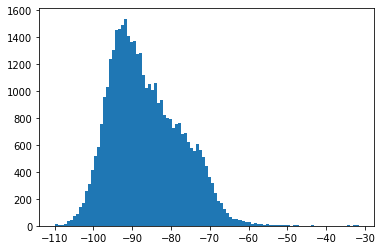

In [8]:
plt.hist(sensor_data_reg[:,0:1:sensors_num], bins='auto')

In [8]:
# Saving images once to save time
# run this cell just for creating images
def creating_image(start, end):
    # for image_num in range(115, data_reg.shape[0]):
    # for image_num in range(1625, 5000):
    for image_num in tqdm.tqdm(range(start, end+1)):  #4463, data_reg.shape[0]
        image = create_image(pu_data=pu_data_reg[image_num],
                             sensor_data=sensor_data_reg[image_num],
                             slope=slope, style=style, 
                             noise_floor=noise_floor,
                             pu_shape=pu_shape, su_shape=su_shape, su_param=su_param, 
                             sensors_num=sensors_num, 
                             intensity_degradation=intensity_degradation, 
                             max_pu_power=0.0)
        if style == "image_intensity":
            if number_image_channels != 3:
                image = np.append(np.array(image[0]), np.zeros((3-number_image_channels,max_x, max_y), 
                                                               dtype=float_memory_used), axis=0)
            image_save = np.swapaxes(image, 0, 2)
            plt.imsave(image_dir + '/image' + str(image_num)+'.png', image_save)
        elif style == "raw_power_min_max_norm" or style == "raw_power_zscore_norm":
    #         np.save(image_dir + '/image' + str(image_num), image)
            np.savez_compressed(image_dir + '/image' + str(image_num), a=image)
        del image
        

In [19]:
jobs = []
proc_sizes = [pu_data_reg.shape[0]//number_of_proccessors] * (number_of_proccessors)
proc_sizes[-1] += pu_data_reg.shape[0]%number_of_proccessors
proc_idx = [(sum(proc_sizes[:i]), sum(proc_sizes[:i+1])-1) for i in range(number_of_proccessors)]

for i in range(number_of_proccessors):
    p = Process(target=creating_image, args=(proc_idx[i][0], proc_idx[i][1]))
    jobs.append(p)
    p.start()
for i in range(number_of_proccessors):
    jobs[i].join()

for i in range(number_of_proccessors):
    jobs[i].terminate()
    jobs[i].close()
del jobs

100%|██████████| 3000/3000 [2:31:11<00:00,  3.02s/it]


In [ ]:
for idx, point in enumerate(sensors_location):
    print(idx+1, point)

In [ ]:
for idx, point in enumerate(sensors_location):
    print(idx+1, point,"close") if math.sqrt((point.x-917)**2+(point.y-415)**2)<=1.5 else None

In [ ]:
count = [0, 0, 0, 0]
idxx = [[],[],[],[]]
for i in range(data_reg.shape[0]):
    pus_c = int(data_reg[i][0]) * 3 + 1
    idx = int(data_reg[i][pus_c]) - 1
    count[idx] += 1
    idxx[idx].append(i)

In [ ]:
print(count)
print(idxx[3])

In [14]:
imm = read_image(0)

In [ ]:
imm[300].shape

In [ ]:
data_reg[:,-1].shape

In [10]:
print(pu_data_reg[0])
print(sensor_data_reg[0])

[ 13.     72.     34.    -23.555  36.     65.    -17.024  83.     86.
 -20.172  51.      4.     -0.146  68.     70.    -18.061  14.     38.
 -27.592  62.     60.     -3.984   6.     41.    -10.137  96.     29.
 -23.763  26.      4.    -28.16    6.     51.     -2.209  68.     92.
 -18.183  46.     15.    -13.68    1.     76.     43.     26.424   0.
     nan     nan     nan     nan     nan     nan     nan     nan     nan
     nan     nan     nan     nan     nan     nan     nan     nan     nan
     nan     nan     nan   3.795]
[-88.826 -90.912 -90.741 ...  26.424   0.      3.795]


In [19]:
number_image_channels

22

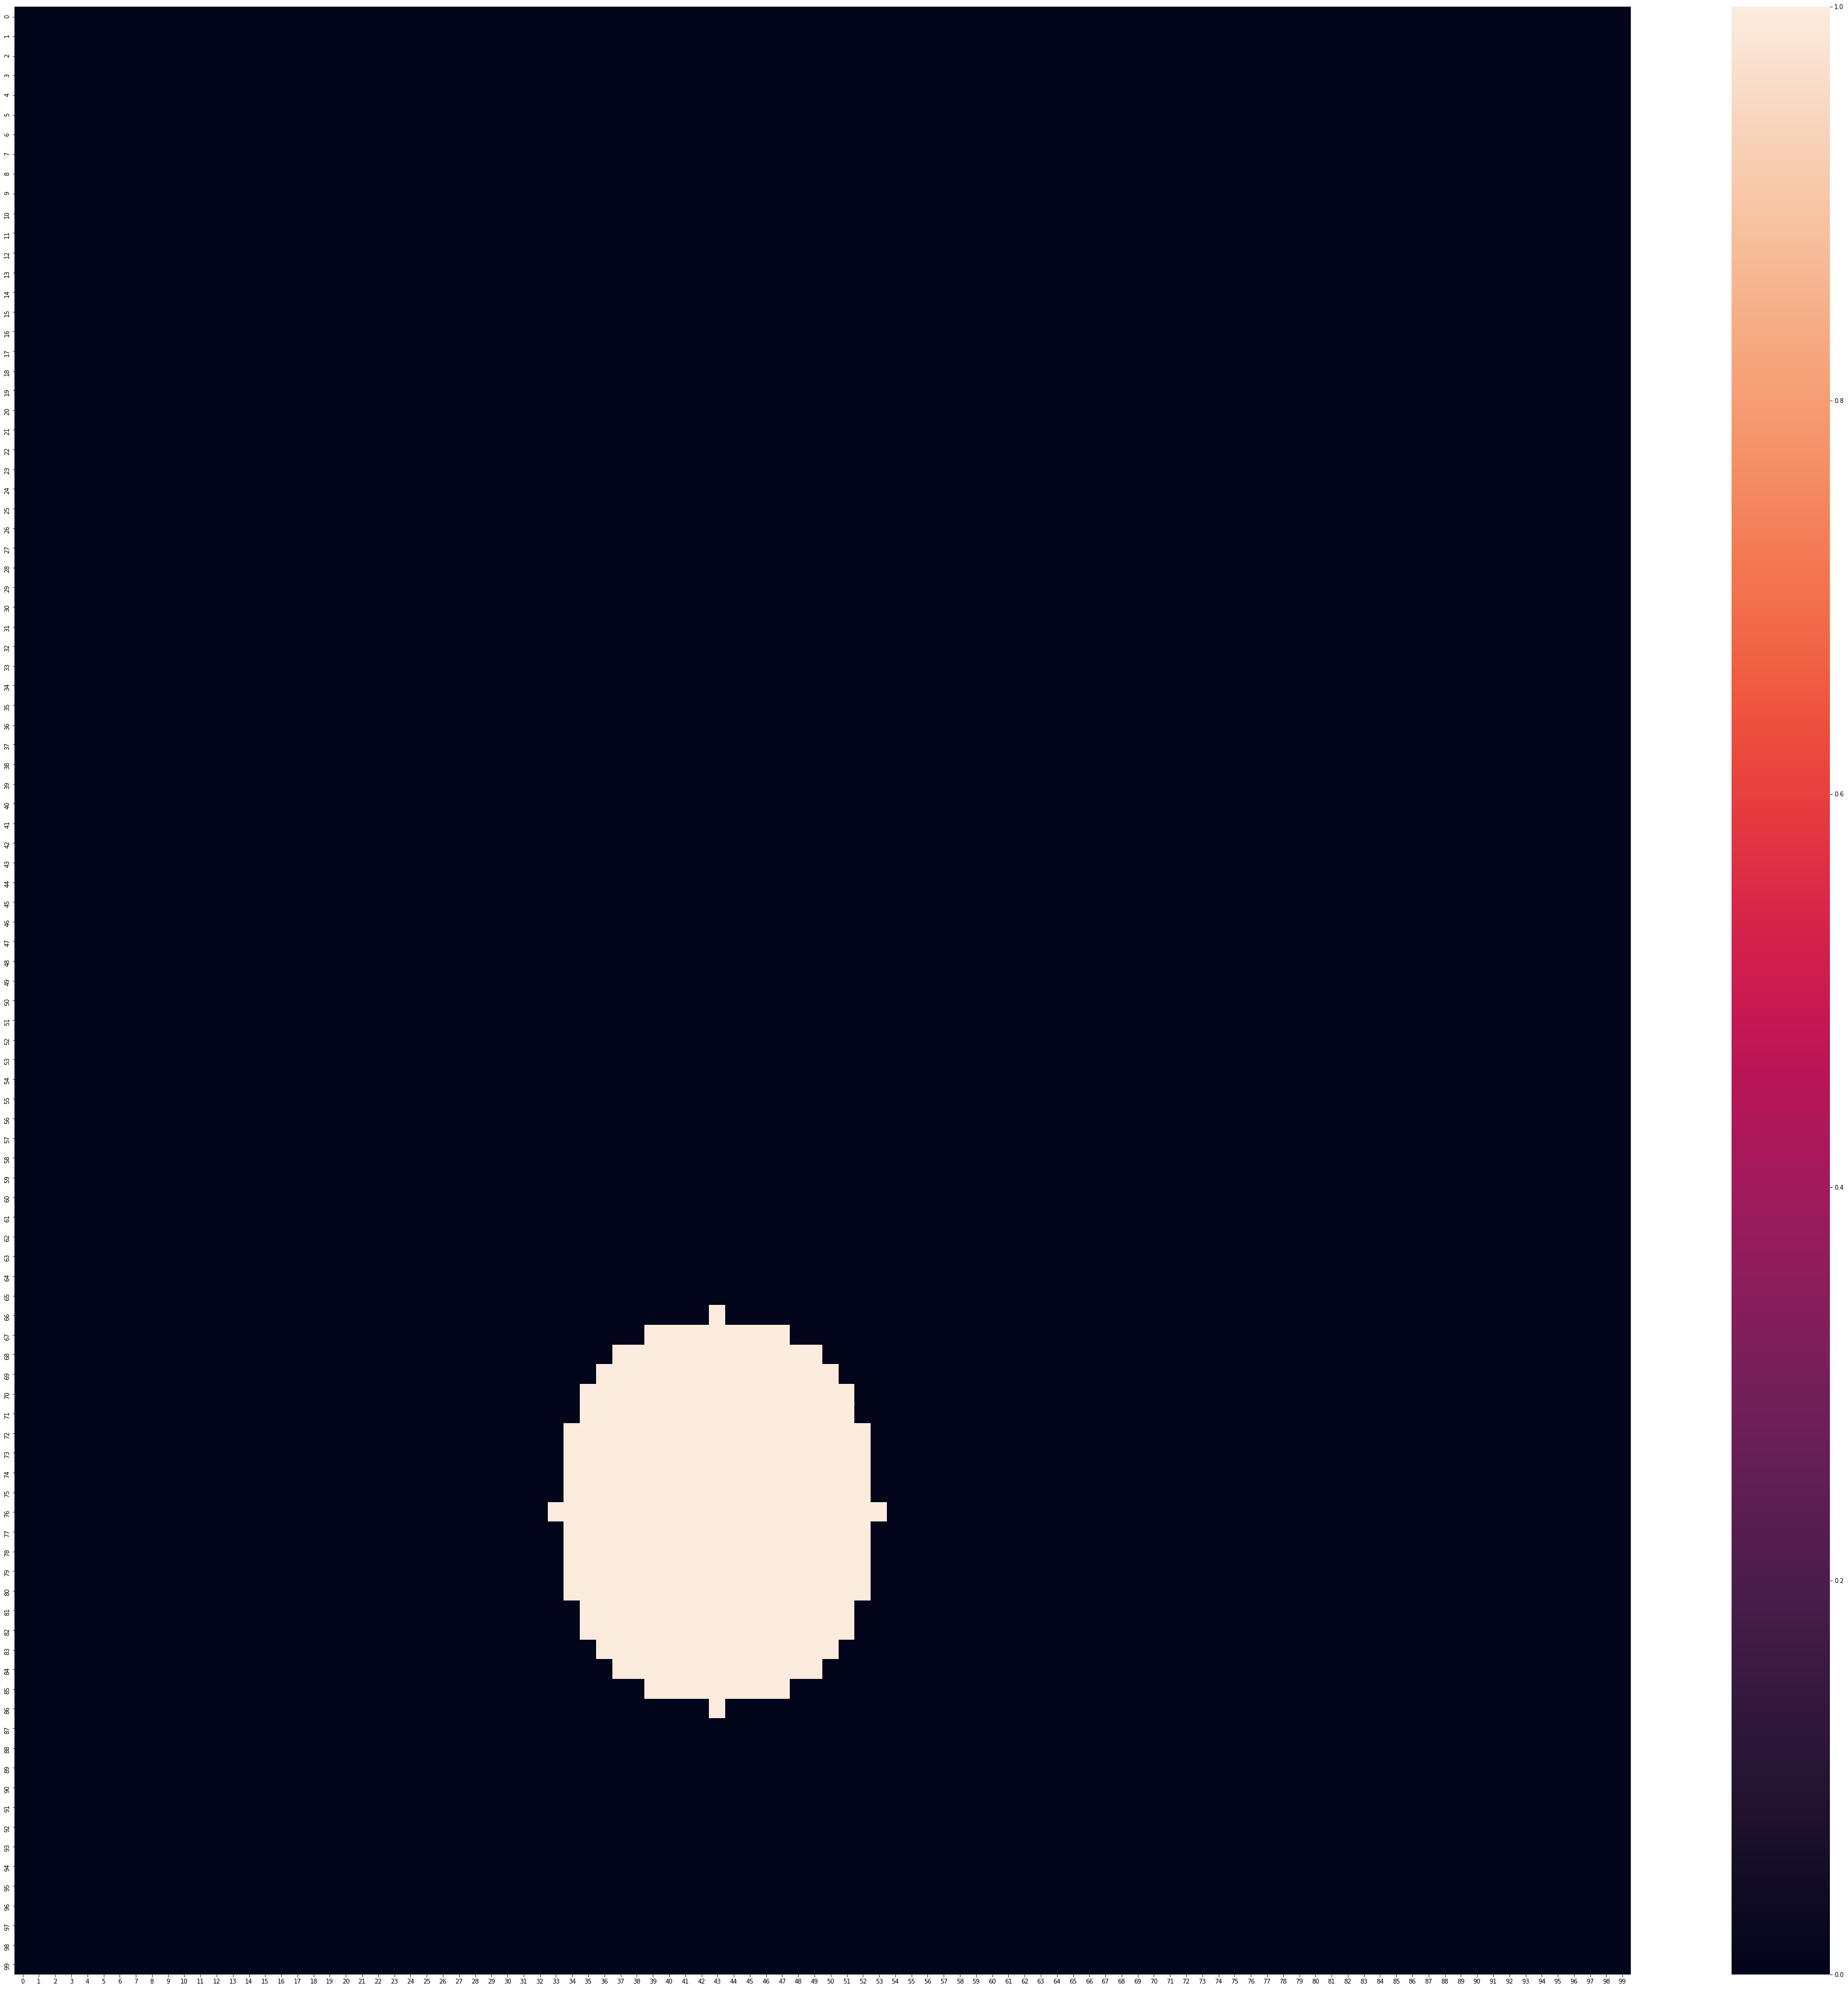

In [18]:
fig, ax = plt.subplots(figsize=(60,60))         # Sample figsize in inches
sns.heatmap(imm[0][7], ax=ax)

In [9]:
def cnn_model(num_filters, kernel_lam, bias_lam):
#     num_filters, lam = 5, 5
    data_format = 'channels_first'
    convolution_init, dense_init = "lecun_normal", "RandomNormal"
    convolution_filter, dense_filter = 'selu', 'linear' #softsign, sigmoid; relu, linear
    filter_shape, pool_size = (3, 3), (2,2)
    cnn = models.Sequential()
    cnn.add(layers.Conv2D(num_filters, filter_shape, padding='same', activation=convolution_filter, 
                          input_shape=(number_image_channels, max_x, max_y), data_format=data_format,
                          kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
                          kernel_initializer=convolution_init))
#     cnn.add(BatchNormalization(axis=1))
#     cnn.add(layers.Conv2D(4*num_filters, filter_shape, padding='same', activation=convolution_filter, 
#                           input_shape=(number_image_channels, max_x, max_y), data_format=data_format,
#                           kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
#                           kernel_initializer='lecun_normal'))
    cnn.add(layers.MaxPooling2D(pool_size=pool_size, data_format=data_format))
    cnn.add(BatchNormalization(axis=1))
#     cnn.add(layers.Dropout(0.25))
    
    cnn.add(layers.Conv2D(2*num_filters, filter_shape,padding='same', activation=convolution_filter, data_format=data_format, 
                         kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
                         kernel_initializer=convolution_init))
#     cnn.add(BatchNormalization(axis=1))
#     cnn.add(layers.Conv2D(3*num_filters, filter_shape, padding='same', activation=convolution_filter, 
#                           input_shape=(number_image_channels, max_x, max_y), data_format=data_format,
#                           kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
#                           kernel_initializer='lecun_normal'))
    cnn.add(layers.MaxPooling2D(pool_size=pool_size, data_format=data_format))
    cnn.add(BatchNormalization(axis=1))
#     cnn.add(layers.Dropout(0.25))
    
    cnn.add(layers.Conv2D(3*num_filters, filter_shape, padding='same', activation=convolution_filter, data_format=data_format, 
                         kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
                         kernel_initializer=convolution_init))
#     cnn.add(BatchNormalization(axis=1))
#     cnn.add(layers.Conv2D(2*num_filters, filter_shape, padding='same', activation=convolution_filter, 
#                           input_shape=(number_image_channels, max_x, max_y), data_format=data_format,
#                           kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
#                           kernel_initializer='lecun_normal'))
    cnn.add(layers.MaxPooling2D(pool_size, data_format=data_format))
    cnn.add(BatchNormalization(axis=1))
#     cnn.add(layers.Dropout(0.25))
    
    cnn.add(layers.Conv2D(4*num_filters, filter_shape, padding='same', activation=convolution_filter, data_format=data_format, 
                         kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
                         kernel_initializer=convolution_init))
#     cnn.add(BatchNormalization(axis=1))
#     cnn.add(layers.Conv2D(num_filters, filter_shape, padding='same', activation=convolution_filter, data_format=data_format, 
#                          kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
#                          kernel_initializer='lecun_normal'))
    cnn.add(layers.MaxPooling2D(pool_size, data_format=data_format))
    cnn.add(BatchNormalization(axis=1))
#     cnn.add(layers.Dropout(0.25))
# from here for 1000
    if max(max_x, max_y) == 1000:
        cnn.add(layers.Conv2D(4*num_filters, filter_shape, padding='same', activation=convolution_filter, data_format=data_format, 
                             kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
                             kernel_initializer=convolution_init))
    #     cnn.add(BatchNormalization(axis=1))
    #     cnn.add(layers.Conv2D(num_filters, filter_shape, padding='same', activation=convolution_filter, data_format=data_format, 
    #                          kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
    #                          kernel_initializer='lecun_normal'))
        cnn.add(layers.MaxPooling2D(pool_size, data_format=data_format))
        cnn.add(BatchNormalization(axis=1))
    #     cnn.add(layers.Dropout(0.25))

        cnn.add(layers.Conv2D(4*num_filters, filter_shape, padding='same', activation=convolution_filter, data_format=data_format, 
                             kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam), 
                             kernel_initializer=convolution_init))
    #     cnn.add(BatchNormalization(axis=1))
    #     cnn.add(layers.Conv2D(2*num_filters, filter_shape, padding='same', activation=convolution_filter, data_format=data_format, 
    #                          kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
    #                          kernel_initializer='lecun_normal'))
        cnn.add(layers.MaxPooling2D(pool_size, data_format=data_format))
        cnn.add(BatchNormalization(axis=1))
    #     cnn.add(layers.Dropout(0.25))

        cnn.add(layers.Conv2D(4*num_filters, filter_shape, padding='same', activation=convolution_filter, data_format=data_format, 
                             kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam), 
                             kernel_initializer=convolution_init))
    #     cnn.add(BatchNormalization(axis=1))
    #     cnn.add(layers.Conv2D(3*num_filters, filter_shape, padding='same', activation=convolution_filter, data_format=data_format, 
    #                          kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
    #                          kernel_initializer='lecun_normal'))
        cnn.add(layers.MaxPooling2D(pool_size, data_format=data_format))
        cnn.add(BatchNormalization(axis=1))
    #     cnn.add(layers.Dropout(0.25))
    
    cnn.add(layers.Flatten())
    cnn.add(layers.Dense(20, activation=convolution_filter, kernel_regularizer=regularizers.l2(kernel_lam),
                         bias_regularizer=regularizers.l2(bias_lam), kernel_initializer=convolution_init))
    cnn.add(BatchNormalization())
    cnn.add(layers.Dense(20, activation=convolution_filter, kernel_regularizer=regularizers.l2(kernel_lam),
                         bias_regularizer=regularizers.l2(bias_lam), kernel_initializer=convolution_init))
#     cnn.add(BatchNormalization())
    cnn.add(layers.Dense(1, activation=dense_filter, kernel_regularizer=regularizers.l2(kernel_lam),
                         bias_regularizer=regularizers.l2(bias_lam), kernel_initializer=dense_init))
    return cnn


class DataBatchGenerator(Sequence):
    def __init__(self, dataset:np.ndarray, batch_size:int, start_idx:int,
                 number_image_channels:int,
                 max_x, max_y, float_memory_used, conserve=0):
#         print(dataset.shape[0])
        self.dataset, self.batch_size, self.start_idx = dataset, batch_size, start_idx
        self.number_image_channels, self.max_x, self.max_y = number_image_channels, max_x, max_y
        self.float_memory_used = float_memory_used
        self.conserve = conserve
    
    def __len__(self):
        return np.ceil(self.dataset.shape[0] / self.batch_size).astype(np.int)
    
    def __getitem__(self, idx):
        size = min(self.dataset.shape[0] - idx * self.batch_size, self.batch_size)
        batch_x = np.empty((size, self.number_image_channels, self.max_x, self.max_y), dtype=self.float_memory_used)
        batch_y = np.empty((size), dtype=self.float_memory_used)
        for i in range(size):
            batch_x[i] = read_image(self.start_idx + idx * self.batch_size + i)
            batch_y[i] = self.dataset[idx * self.batch_size + i][- 1 - self.conserve]
        return batch_x, batch_y
    
def custom_loss(fp_penalty_coef, fn_penalty_coef):
    # custom loss function that penalize false positive and negative differently
    def loss(y_true, y_pred):
        res = y_pred - y_true
        res = tf.where(res > 0, res * fp_penalty_coef, res * fn_penalty_coef)
        return K.mean(K.square(res))
    return loss

def fp_mae(y_true, y_pred):
    # custom metric that replace false negative with zero and return the mean of new vector
    res = y_pred - y_true
    res = tf.nn.relu(res)
#     res = tf.where(res <= 0, 0, res)
    return K.mean(res)
         

In [10]:
cnn = cnn_model(10, 0, 0)

In [11]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 10, 100, 100)      730       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 10, 50, 50)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 10, 50, 50)        40        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 20, 50, 50)        1820      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 20, 25, 25)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 20, 25, 25)        80        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 25, 25)        5

In [12]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [13]:
number_samples = [8192]

In [21]:
# CNN: support batching
TEST, CONSERVE = True, False
mini_batch = 16 if max(max_x, max_y) == 1000 else 512
epochs = 35 if max(max_x, max_y) == 1000 else 100
MAX_QUEUE_SIZE, WORKERS = 6, 1
fp_penalty_coef, fn_penalty_coef = 1, 1
hyper_metric, mode = "val_mae", 'min'  # the metric that hyper parameters are tuned with
prev_sample = 0
lambda_vec = [0, 0.001, 0.01, 0.1, 1]  #0.003, 0.01, 0.03, 0.1, 0.3, 1, 3
# lambda_vec = [0.01, 0.1, 1]
lambda_vec = [0.01]
# MODEL_PATH = 'models/'
average_diff_power, fp_mean_power = [],[] #[7.177, 8.088, 8.183], [3.438, 3.506, 2.662]
best_lambda = []
average_diff_power_conserve, fp_mean_power_conserve = [], []
all_cnns, all_checkpointers = [], []
if CONSERVE: # for conservative
    prev_number_samples = [0] + number_samples[:-1]

for num_sample_idx, number_sample in enumerate(number_samples):
#     if num_sample_idx < 3:
#         continue
#     if num_sample_idx == 0:
    if CONSERVE:
        pu_data_reg[prev_number_samples[num_sample_idx]:number_sample, -1] = pu_data_reg[
            prev_number_samples[num_sample_idx]:number_sample, -1] - 1 # conserv value
    MODEL_PATH = '/'.join(image_dir.split('/')[:-1]) + '/models/' + str(number_sample)
    if not os.path.exists(MODEL_PATH):
        os.makedirs(MODEL_PATH)
    MODEL_PATH += "/best_model_lambda_"
    if True:
        cnns = [cnn_model(10, lamb, 0) for lamb in lambda_vec]
        for cnn in cnns:
#             cnn.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse','mae', fp_mean])
            cnn.compile(loss=custom_loss(fp_penalty_coef, fn_penalty_coef), 
                        optimizer='Adam', 
                        metrics=['mse', 'mae', fp_mae])
        checkpointers = [ModelCheckpoint(filepath=MODEL_PATH + str(lamb_idx)+ '.h5',
                                         verbose=1, save_best_only=True, 
                                         monitor=hyper_metric,
                                         mode=mode)
                         for lamb_idx in range(len(lambda_vec))]
    else:
        cnns = []
        cnns = [models.load_model(MODEL_PATH + str(lamb_idx) + '.h5', 
                                  custom_objects={ 'loss': custom_loss(fp_penalty_coef, fn_penalty_coef), 
                                                  'fp_mae': fp_mae }) 
                for lamb_idx in range(len(lambda_vec))]
    number_start = time.time()
    train_generator = DataBatchGenerator(dataset=pu_data_reg[prev_sample:number_sample],
                                         batch_size=mini_batch,
                                         start_idx=prev_sample, 
                                         number_image_channels=number_image_channels,
                                         max_x=max_x, max_y=max_y,
                                         float_memory_used=float_memory_used)
    

    val_size = math.ceil(number_sample * validation_size)
    val_generator = DataBatchGenerator(dataset=pu_data_reg[number_sample:number_sample+val_size], 
                                       batch_size=mini_batch,
                                       start_idx=number_sample,
                                       number_image_channels=number_image_channels,
                                       max_x=max_x, max_y=max_y, 
                                       float_memory_used=float_memory_used)
  
    print('number_samples:', number_sample, ", New samples:", number_sample - prev_sample)
    print("Validation size:", val_size, ", starts:", number_sample, ", ends:", number_sample + val_size - 1)
    
    for lamb_idx, lamb in enumerate(lambda_vec):
#     for lamb_idx, lamb in enumerate(lambda_vec[:len(lambda_vec) - num_sample_idx//2]):
#         if num_sample_idx == 3 and lamb_idx < 4:
#             continue
        lambda_start = time.time()
        cnns[lamb_idx].fit(train_generator, epochs=epochs, verbose=0,
                           validation_data=val_generator, 
                           shuffle=True, callbacks=[checkpointers[lamb_idx]], 
                           workers=WORKERS, max_queue_size=MAX_QUEUE_SIZE, 
                           use_multiprocessing=False)
        
        print("\nLambda:", lamb, ", Time:", str(datetime.timedelta(seconds=int(time.time() - lambda_start))))
        print("Train Error(all epochs):", min(cnns[lamb_idx].history.history['mae']), '\n', 
              [round(val, 3) for val in cnns[lamb_idx].history.history['mae']])
        print("Train FP Error(all epochs):", min(cnns[lamb_idx].history.history['fp_mae']), '\n',
              [round(val,3) for val in cnns[lamb_idx].history.history['fp_mae']])
        print("Val Error(all epochs):", min(cnns[lamb_idx].history.history['val_mae']), '\n', 
              [round(val,3) for val in cnns[lamb_idx].history.history['val_mae']])
        print("Val FP Error(all epochs):", min(cnns[lamb_idx].history.history['val_fp_mae']), '\n',
              [round(val,3) for val in cnns[lamb_idx].history.history['val_fp_mae']])
#     if num_sample_idx == 3:    
#         models_min_mae = [8.27781, 8.23545, 8.20838, 7.74743]
#         models_min_mae += [min(cnns[lamb_idx].history.history[hyper_metric]) for lamb_idx in range(4,lamb_idx+1)]
#     else:
    models_min_mae = [min(cnns[lam_idx].history.history[hyper_metric]) for
                      lam_idx,_ in enumerate(lambda_vec)]
    best_lamb_idx = models_min_mae.index(min(models_min_mae))
    best_lambda.append(lambda_vec[best_lamb_idx])
    print("\nTrainig set size:", number_sample, ", Time:", str(datetime.timedelta(seconds=int(time.time() - 
                                                                                              number_start))),
          ", best_lambda:", lambda_vec[best_lamb_idx], ", min_" , ("fp_" if hyper_metric == "val_fp_mae" else ""),
          "error:", round(min(models_min_mae), 3))
    
    if TEST:
        # evaluating test images
        best_model = None
        best_model = models.load_model(MODEL_PATH + str(best_lamb_idx) + '.h5', 
                                       custom_objects={ 'loss': custom_loss(fp_penalty_coef, fn_penalty_coef), 
                                                       'fp_mae': fp_mae,
                                                      'mae':'mae', 'mse':'mse'})
        test_generator = DataBatchGenerator(dataset=pu_data_reg[number_sample + val_size:], 
                                            batch_size=mini_batch,
                                            start_idx=number_sample + val_size, 
                                            number_image_channels=number_image_channels,
                                            max_x=max_x, max_y=max_y, float_memory_used=float_memory_used)

        print("Test starts: ", number_sample + val_size, ", ends: ", pu_data_reg.shape[0] - 1)
        time.sleep(1)
        test_res = best_model.evaluate(test_generator, verbose=1, 
                                       workers=WORKERS, max_queue_size=MAX_QUEUE_SIZE, use_multiprocessing=False)
        
        test_mae_idx, test_fp_mae_idx = [best_model.metrics_names.index(mtrc) 
                                         for mtrc in ['mae','fp_mae']]
        test_mae, test_fp_mae = test_res[test_mae_idx], test_res[test_fp_mae_idx]
        average_diff_power.append(round(test_mae, 3))
        fp_mean_power.append(round(test_fp_mae, 3))
        print('average_error: ', average_diff_power[-1], ', fp_average_error: ', 
              fp_mean_power[-1])
        
        if False:
            test_generator_conserve = DataBatchGenerator(dataset=pu_data_reg[number_sample + val_size:], 
                                                         batch_size=mini_batch,
                                                         start_idx=number_sample + val_size, 
                                                         number_image_channels=number_image_channels,
                                                         max_x=max_x, max_y=max_y, 
                                                         float_memory_used=float_memory_used, 
                                                         conserve=1)
            test_res_conserve = best_model.evaluate(test_generator_conserve, verbose=1, 
                                                    workers=WORKERS, max_queue_size=MAX_QUEUE_SIZE, 
                                                    use_multiprocessing=False)
            test_mae_cons, test_fp_mae_cons = test_res_conserve[test_mae_idx], test_res_conserve[test_fp_mae_idx]
            average_diff_power_conserve.append(round(test_mae_cons, 3))
            fp_mean_power_conserve.append(round(test_fp_mae_cons, 3))
            print('Conserve, average_error: ', average_diff_power_conserve[-1], ', fp_average_error: ',
                 fp_mean_power_conserve[-1])
        print("\n\n")

        
        var_f = open('/'.join(image_dir.split('/')[:-1]) +  '/' + intensity_degradation + '_' + str(slope) + '_' + 
                     dtime + ".dat", "wb") # file for saving results
        pickle.dump([average_diff_power, fp_mean_power, number_samples, best_lambda, 
                     pu_dataset_name, sensor_dataset_name,
                     max_dataset_name, average_diff_power_conserve, fp_mean_power_conserve,
                    all_cnns, all_checkpointers],
                    file=var_f)
        var_f.close()
        all_cnns.append(cnns)
        all_checkpointers.append(checkpointers)
        del cnns, train_generator, val_generator, checkpointers
        del best_model, test_generator
#     prev_sample = number_sample

number_samples: 8192 , New samples: 8192
Validation size: 2704 , starts: 8192 , ends: 10895

Epoch 00001: val_mae improved from inf to 9.78520, saving model to ML/data/pictures_100_100/splat/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/3600sensors_pus/models/8192/best_model_lambda_0.h5

Epoch 00002: val_mae did not improve from 9.78520

Epoch 00003: val_mae improved from 9.78520 to 9.51208, saving model to ML/data/pictures_100_100/splat/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/3600sensors_pus/models/8192/best_model_lambda_0.h5

Epoch 00004: val_mae improved from 9.51208 to 9.47149, saving model to ML/data/pictures_100_100/splat/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/3600sensors_pus/models/8192/best_model_lambda_0.h5

Epoch 00005: val_mae improved from 9.47149 to 7.91613, saving model to ML/data/pictures_100_100/splat/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/3600sensors_pus/models/8192/best_model_lambda_0.h5

Epoch 00006:

Test starts:  10896 , ends:  29999
38/38 [==============================] - 22s 571ms/step - loss: 34.1477 - mse: 32.3247 - mae: 4.3490 - fp_mae: 2.3934
average_error:  4.349 , fp_average_error:  2.393





In [14]:
print(number_samples)
print(average_diff_power)
print(fp_mean_power)
# print(best_lambda)
print(average_diff_power_conserve)
print(fp_mean_power_conserve)
print(best_lambda)

[256, 512, 1024, 2048, 4096, 8192]
[7.304, 7.435, 6.058, 5.099, 4.514, 3.998]
[3.036, 3.115, 3.43, 2.506, 2.0, 2.144]
[]
[]
[0.01, 0.01, 0.1, 0.001, 1, 0.01]


In [22]:
all_cnns[0][0].history.history

{'loss': [34.280517578125,
  32.139129638671875,
  30.026790618896484,
  26.77768898010254,
  22.154972076416016,
  16.8223819732666,
  12.144721984863281,
  9.570384979248047,
  7.8615312576293945,
  6.511453151702881,
  5.97813606262207,
  5.705277919769287,
  5.531862258911133,
  5.38530158996582,
  5.206046104431152,
  5.079604148864746,
  4.93232536315918,
  4.80665922164917,
  4.676588535308838,
  4.540332794189453,
  4.43764066696167,
  4.290816307067871,
  4.191329002380371,
  4.067809104919434,
  4.628100395202637,
  6.274977684020996,
  5.784174919128418,
  5.09354829788208,
  4.657415866851807,
  4.24078369140625,
  3.9520764350891113,
  3.7179880142211914,
  3.524243116378784,
  3.3813459873199463,
  3.3246569633483887,
  3.348724126815796,
  3.2289745807647705,
  3.259772300720215,
  3.4742321968078613,
  3.3629093170166016,
  3.278648853302002,
  3.1227707862854004,
  3.1056971549987793,
  3.05012845993042,
  2.9284372329711914,
  2.980515241622925,
  3.0709378719329834,


In [51]:
best_model = all_cnns[0][0]
checkpointers = all_checkpointers[0][0]

In [52]:
checkpointers

In [54]:
if True:
#     checkpointers = ModelCheckpoint(filepath=MODEL_PATH + str(0)+ 'new.h5',
#                                          verbose=1, save_best_only=True, 
#                                          monitor=hyper_metric,
#                                          mode=mode)
    number_start = time.time()
    train_generator = DataBatchGenerator(dataset=pu_data_reg[prev_sample:number_sample], batch_size=mini_batch,
                                         start_idx=prev_sample, number_image_channels=number_image_channels,
                                         max_x=max_x, max_y=max_y, float_memory_used=float_memory_used)
    

    val_size = math.ceil(number_sample * validation_size)
    val_generator = DataBatchGenerator(dataset=pu_data_reg[number_sample:number_sample+val_size], 
                                       batch_size=mini_batch,
                                       start_idx=number_sample,
                                       number_image_channels=number_image_channels,
                                       max_x=max_x, max_y=max_y, 
                                       float_memory_used=float_memory_used)
  
    print('number_samples:', number_sample, ", New samples:", number_sample - prev_sample)
    print("Validation size:", val_size, ", starts:", number_sample, ", ends:", number_sample + val_size - 1)
    best_model.fit(train_generator, epochs=300, verbose=0,
                   validation_data=val_generator, shuffle=True, callbacks=[checkpointers], 
                   workers=WORKERS, max_queue_size=MAX_QUEUE_SIZE, 
                   use_multiprocessing=False, initial_epoch=201)
    print("Train Error(all epochs):", min(best_model.history.history['mae']), '\n',
          [round(val, 3) for val in best_model.history.history['mae']])
    print("Train FP Error(all epochs):", min(best_model.history.history['fp_mae']), '\n',
          [round(val,3) for val in best_model.history.history['fp_mae']])
    print("Val Error(all epochs):", min(best_model.history.history['val_mae']), '\n', 
          [round(val,3) for val in best_model.history.history['val_mae']])
    print("Val FP Error(all epochs):", min(best_model.history.history['val_fp_mae']), '\n',
          [round(val,3) for val in best_model.history.history['val_fp_mae']])
    

number_samples: 4096 , New samples: 4096
Validation size: 1352 , starts: 4096 , ends: 5447

Epoch 00202: val_mae did not improve from 4.91669

Epoch 00203: val_mae did not improve from 4.91669

Epoch 00204: val_mae did not improve from 4.91669

Epoch 00205: val_mae did not improve from 4.91669

Epoch 00206: val_mae did not improve from 4.91669

Epoch 00207: val_mae did not improve from 4.91669

Epoch 00208: val_mae did not improve from 4.91669

Epoch 00209: val_mae did not improve from 4.91669

Epoch 00210: val_mae did not improve from 4.91669

Epoch 00211: val_mae did not improve from 4.91669

Epoch 00212: val_mae did not improve from 4.91669

Epoch 00213: val_mae did not improve from 4.91669

Epoch 00214: val_mae did not improve from 4.91669

Epoch 00215: val_mae did not improve from 4.91669

Epoch 00216: val_mae did not improve from 4.91669

Epoch 00217: val_mae did not improve from 4.91669

Epoch 00218: val_mae did not improve from 4.91669

Epoch 00219: val_mae did not improve from

KeyboardInterrupt: 

In [27]:
best_best_model = models.load_model(MODEL_PATH + str(0) + 'new.h5', 
                               custom_objects={ 'loss': custom_loss(fp_penalty_coef, fn_penalty_coef), 
                                               'fp_mae': fp_mae,
                                               'mae':'mae', 'mse':'mse'})
test_generator = DataBatchGenerator(dataset=pu_data_reg[number_sample + val_size:], 
                                            batch_size=mini_batch,
                                            start_idx=number_sample + val_size, 
                                            number_image_channels=number_image_channels,
                                            max_x=max_x, max_y=max_y, float_memory_used=float_memory_used)

print("Test starts: ", number_sample + val_size, ", ends: ", pu_data_reg.shape[0] - 1)
time.sleep(1)
test_res = best_best_model.evaluate(test_generator, verbose=1, 
                                    workers=WORKERS, max_queue_size=MAX_QUEUE_SIZE,
                                    use_multiprocessing=False)

Test starts:  681 , ends:  29999
58/58 [==============================] - 34s 582ms/step - loss: 105.1952 - mse: 103.6270 - mae: 8.1336 - fp_mae: 3.3546


In [60]:
test_res

[496.0564270019531, 56.21223449707031, 5.682240009307861, 1.5113146305084229]

In [56]:
best_model.history.history

{'loss': [105.50102233886719,
  100.78263854980469,
  99.25178527832031,
  104.09859466552734,
  104.50546264648438],
 'mse': [44.08177185058594,
  41.80543518066406,
  41.379180908203125,
  44.375244140625,
  44.21040725708008],
 'mae': [5.269191265106201,
  5.1021318435668945,
  5.071562767028809,
  5.278663635253906,
  5.268550872802734],
 'fp_mae': [0.19422784447669983,
  0.1903233528137207,
  0.19018331170082092,
  0.2034783661365509,
  0.19720497727394104],
 'val_loss': [396.6565246582031,
  401.5822448730469,
  435.2545166015625,
  567.9744262695312,
  345.01153564453125],
 'val_mse': [120.43984985351562,
  76.076171875,
  161.7263946533203,
  71.23866271972656,
  77.79705047607422],
 'val_mae': [9.087770462036133,
  6.748907089233398,
  10.751054763793945,
  6.494345188140869,
  6.804019927978516],
 'val_fp_mae': [0.6868877410888672,
  0.9997519850730896,
  0.640586793422699,
  1.5676021575927734,
  0.9557649493217468]}

In [50]:
best_model.fit(train_generator, epochs=15, verbose=0,
               validation_data=val_generator, shuffle=True, callbacks=[checkpointers], 
               workers=WORKERS, max_queue_size=MAX_QUEUE_SIZE, 
               use_multiprocessing=False, initial_epoch=20)

In [ ]:
models_min_mae = [8.27781, 8.23545, 8.20838]

In [ ]:
average_diff_power = [8.166, 7.844, 7.592]
fp_mean_power = [4.56, 4.42, 4.37]

In [ ]:
# CNN: support batching
TEST = True
mini_batch, epochs = 16, 30
batch_size = (batch_size // mini_batch) * mini_batch
prev_sample = 0
lambda_vec = [0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10]  #, 0.3, 1, 3, 10
average_diff_power, fp_mean_power = [], []
cnns = [cnn_model(10, lamb, 0) for lamb in lambda_vec]
for cnn in cnns:
    cnn.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse','mae'])
for number_sample in number_samples:
    number_start = time.time()
    current_sample = number_sample - prev_sample
    train_samples = [batch_size] * (current_sample//batch_size) + ([current_sample%batch_size] if 
                                                                    current_sample%batch_size else [])
    val_size = math.ceil(number_sample * validation_size)
#     val_samples = [batch_size] * (val_size//batch_size) + ([val_size%batch_size] if 
#                                                                val_size%batch_size else [])
    
    print('number_samples:', number_sample)
    print("Train batches:", train_samples)
    for i, train_sample in enumerate(train_samples):
        print("Train batch#:", i, ", batch size:", train_sample, ", starts:", prev_sample + i * batch_size,
                      ", ends:", prev_sample + i * batch_size + train_sample - 1)
    print("Validation size:", val_size, ", starts:", number_sample, ", ends:", number_sample + val_size - 1)
#     print("Validation Batches:", val_samples)
#     for i, val_sample in enumerate(val_samples):
#         print("Validation batch#:", i, ", batch size:", val_sample, ", starts:", number_sample + i * batch_size,
#                       ", ends:", number_sample + i * batch_size + val_sample - 1)
        
    min_error = float('inf')
    best_model, best_lam = None, None
    for lamb_idx, lamb in enumerate(lambda_vec):
        lambda_start = time.time()
        
#         cnn = cnn_model(10, lamb, 0)
#         cnn.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse','mae'])
        
        # training on all batches
        for i, train_sample in enumerate(train_samples):
#             if lamb_idx == 0:
#                 print("Train batch#:", i, ", batch size:", train_sample, ", starts:", prev_sample + i * batch_size,
#                       ", ends:", prev_sample + i * batch_size + train_sample - 1)
            x_train = np.empty((train_sample, number_image_channels, max_x, max_y), dtype=float_memory_used)
            y_train = np.empty((train_sample), dtype=float_memory_used)
            for image_num in range(prev_sample + i * batch_size, prev_sample + i * batch_size + train_sample):
                x_train[(image_num - prev_sample) % batch_size] = read_image(image_num)
                y_train[(image_num - prev_sample) % batch_size] = np.asarray(data_reg[image_num][-1], 
                                                                             dtype=float_memory_used)
            cnns[lamb_idx].fit(x_train, y_train, epochs=epochs, verbose=2, batch_size=mini_batch,
                               validation_split=0.2, 
                               shuffle=True)
            del x_train, y_train
#         if lamb_idx == 0:
#             print("Validation size:", val_size, ", starts:", number_sample, ", ends:", 
#                   number_sample + val_size - 1)
        print("\nLambda:", lamb)
        print("Train Error(all epochs): ", cnns[lamb_idx].history.history['mae'])
        
        # validating
        val_mae, val_fp_mae = 0.0, 0.0
#         for i, val_sample in enumerate(val_samples):
#             x_val = np.empty((val_sample, number_image_channels, max_x, max_y), dtype=float_memory_used)
#             for image_num in range(val_sample):
#                 x_val[image_num] = read_image(image_num + number_sample + i * batch_size)
#             yp_val = cnns[lamb_idx].predict(x_val)
        for image_num in range(val_size):
            val_y = data_reg[image_num + number_sample][-1]
            image = read_image(image_num + number_sample)
            val_yp = cnns[lamb_idx].predict(image)[0][0]
#             for image_num in range(val_sample):
#                 val_yp = yp_val[image_num][0]
#                 val_y = data_reg[image_num + number_sample + i * batch_size][-1]
            val_mae += abs(val_y - val_yp)
            if val_yp > val_y:
                val_fp_mae += abs(val_yp - val_y)
        val_mae /= val_size
        val_fp_mae /= val_size
        print("Val Error:", round(val_mae, 3), ", Time:", str(datetime.timedelta(seconds=int(time.time() - lambda_start))))
        if val_mae < min_error:
            min_error = val_mae
            best_model = cnns[lamb_idx]
            best_lam = lamb
            best_lam_idx = lamb_idx
    print("\nTrainig set size:", number_sample, ", Time:", str(datetime.timedelta(seconds=int(time.time() - number_start)))
          ,", best_lambda:", best_lam, ", min_error:", round(min_error, 3))
    
    
    if TEST:
        # evaluating test images
        sum_mae, sum_fp_mae = 0, 0
        test_size = 0

        y_test_p = np.empty((data_reg.shape[0] - (number_sample + val_size)), dtype=float_memory_used)
    #     test_size = data_reg.shape[0] - (number_sample + val_size)
    #     test_samples = [batch_size] * (test_size//batch_size) + ([test_size%batch_size] if 
    #                                                              test_size%batch_size else [])
        print("Test starts: ", number_sample + val_size, ", ends: ", data_reg.shape[0] - 1)
        time.sleep(1)
    #     for i, test_sample in tqdm.tqdm(enumerate(test_samples)):
    #         x_test = np.empty((test_sample, number_image_channels, max_x, max_y), dtype=float_memory_used)
    #         for image_num in range(test_sample):
    #             x_test[image_num] = read_image(number_sample + val_size + i * batch_size)
    #         yp_test = cnns[best_lam_idx].predict(x_test)
    #         for image_num in range(test_sample):
    #             test_y = data_reg[number_sample + val_size + i * batch_size][-1]
    #             test_yp = yp_test[image_num][0]
    #             sum_mae += abs(test_yp - test_y)
    #             if test_yp > test_y:
    #                 sum_fp_mae += abs(test_yp - test_y)

        for test_num in tqdm.tqdm(range(number_sample + val_size, data_reg.shape[0])):
            test_size += 1
            test_image = read_image(test_num)
            test_y = data_reg[test_num][-1]
            test_yp = best_model.predict(test_image)[0][0]
            y_test_p[test_num - (number_sample + val_size)] = test_yp
            sum_mae += abs(test_yp - test_y)
            if test_yp > test_y:
                sum_fp_mae += abs(test_yp - test_y)
        fp_mean_power.append(round(sum_fp_mae/ test_size, 3))
        average_diff_power.append(round(sum_mae / test_size, 3))
        print('average_error: ', average_diff_power[-1], ', fp_average_error: ', 
              fp_mean_power[-1])
        print("\n\n")
        var_f = open('/'.join(image_dir.split('/')[:-1]) +  '/' + intensity_degradation + '_' + str(slope) + '_' + 
                     dtime + ".dat", "wb") # file for saving results
        pickle.dump([average_diff_power, fp_mean_power, number_samples], file=var_f)
        var_f.close()
    prev_sample = number_sample

In [ ]:
cnns[1].weights

In [ ]:
# CNN: support batching
prev_sample = 0
# number_samples = [120, 200, 700]
lambda_vec = [0, 0.001]  #0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10
average_diff_power, fp_mean_power = [], []
cnns = [cnn_model(10, lamb, 0) for lamb in lambda_vec]
for cnn in cnns:
    cnn.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse','mae'])
for number_sample in number_samples:
    current_sample = number_sample - prev_sample
    print("prev: ", prev_sample, ", now: ", number_sample, ", size", current_sample) 
    train_samples = [batch_size] * (current_sample//batch_size) + ([current_sample%batch_size] if 
                                                                    current_sample%batch_size else [])
    print(train_samples)
    
    min_error = float('inf')
    best_model, best_lam = None, None
    for lamb_idx, lamb in enumerate(lambda_vec):
        print("Lambda:", lamb)
#         cnn = cnn_model(10, lamb, 0)
#         cnn.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse','mae'])
        
        # training on all batches
                                    
        for i, train_sample in enumerate(train_samples):
            for image_num in range(prev_sample + i * batch_size, prev_sample + i * batch_size + train_sample):
                print(prev_sample + i * batch_size, prev_sample + i * batch_size + train_sample)
                print((prev_sample + i * batch_size - prev_sample) % batch_size, 
                      (prev_sample + i * batch_size + train_sample - prev_sample)% batch_size)
                break

        
        # validating
        print("validating")
        val_size = math.ceil(number_sample * validation_size)
        for image_num in range(val_size):
            print(number_sample, val_size + number_sample)
            break
     
    print("Test") 
    
    # evaluating test images

    
    for test_num in tqdm.tqdm(range(number_sample + val_size, data_reg.shape[0])):
        print(number_sample + val_size, data_reg.shape[0])
        break
    prev_sample = number_sample

In [ ]:
var_f = open('/'.join(image_dir.split('/')[:-1]) +  '/' + 'best_cnn_4000samples' + intensity_degradation + '_' + str(slope) + '_' + 
                 dtime + ".dat", "wb") # file for saving results
pickle.dump(best_model, file=var_f)
var_f.close()

In [ ]:
## use self-training
unlabeled_train_samples = [batch_size] * (len(y_test_p)//batch_size) + ([len(y_test_p)%batch_size] if len(y_test_p)%batch_size else [])
labeled_train_samples = [batch_size] * (number_sample//batch_size) + ([number_sample%batch_size] if number_sample%batch_size else [])   
min_min_error = float('inf')
best_best_model, best_best_lam = None, None
for lamb in tqdm.tqdm(lambda_vec):
    print("Lambda:", lamb)
    cnn = cnn_model(10, lamb, 0)
    cnn.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse','mae'])
#     cnn.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse','mae'])
        
    # training on all batches
    # training on all batches
    for i, train_sample in tqdm.tqdm(enumerate(labeled_train_samples)):
        x_train = np.empty((train_sample, number_image_channels, max_x, max_y), dtype=float_memory_used)
        y_train = np.empty((train_sample), dtype=float_memory_used)
        for image_num in range(i * batch_size, i * batch_size + train_sample):
            x_train[image_num % batch_size] = read_image(image_num)
            y_train[image_num % batch_size] = np.asarray(data_reg[image_num][-1], dtype=float_memory_used)
        cnn.fit(x_train, y_train, epochs=6, verbose=0, batch_size=1, validation_split=0.0)
        del x_train, y_train
            
    for i, train_sample in tqdm.tqdm(enumerate(unlabeled_train_samples)):
        x_train = np.empty((train_sample, number_image_channels, max_x, max_y), dtype=float_memory_used)
        y_train = np.empty((train_sample), dtype=float_memory_used)
        for image_num in range(i * batch_size + number_sample + val_size, i * batch_size + number_sample + val_size + train_sample):
            x_train[(image_num-number_sample - val_size) % batch_size] = read_image(image_num)
            y_train[(image_num-number_sample - val_size) % batch_size] = np.asarray(y_test_p[image_num-(number_sample + val_size)], dtype=float_memory_used)
        cnn.fit(x_train, y_train, epochs=3, verbose=0, batch_size=1, validation_split=0.0)
        del x_train, y_train
        
    # validating
    val_size = math.ceil(number_sample * validation_size)
    val_mae, val_fp_mae = 0.0, 0.0
    for image_num in range(val_size):
        val_y = data_reg[image_num + number_sample][-1]
        image = read_image(image_num + number_sample)
        val_yp = cnn.predict(image)[0][0]
        val_mae += abs(val_y - val_yp)
        if val_yp > val_y:
            val_fp_mae += abs(val_yp - val_y)
    val_mae /= val_size
    val_fp_mae /= val_size
    print(val_mae)
    if val_mae < min_min_error:
        min_min_error = val_mae
        best_best_model = cnn
        best_best_lam = lamb
    sum_mae, sum_fp_mae = 0, 0
    test_size = 0
    
for test_num in tqdm.tqdm(range(number_sample + val_size, data_reg.shape[0])):
    test_size += 1
    test_image = read_image(test_num)
    test_y = data_reg[test_num][-1]
    test_yp = best_best_model.predict(test_image)[0][0]
#     y_test_p[test_num - (number_sample + val_size)] = test_yp
    sum_mae += abs(test_yp - test_y)
    if test_yp > test_y:
        sum_fp_mae += abs(test_yp - test_y)
fp_mean_power.append(round(sum_fp_mae/ test_size, 3))
average_diff_power.append(round(sum_mae / test_size, 3))
print('number_samples: ', number_sample, ', average_error: ', average_diff_power[-1], ' fp_average_error: ', 
      fp_mean_power[-1])
print("\n")

In [ ]:
6.285, 6.366, 6.45, 6.454, 6.382, 6.26, 6.49, 6.224, 6.052, 5.87, 4.915, 4.836

In [ ]:
# CNN
prev_sample = 0
lambda_vec = [0, 0.001, 0.003, 0.01, 0.03, 0.1]
max_train_samples = math.ceil(number_samples[-1] * (1 + validation_size))
x_train = np.empty((max_train_samples, number_image_channels, max_x, max_y), dtype=float_memory_used)
# x_train1 = np.empty((max_train_samples, 1, max_x, max_y), dtype=float_memory_used)
# x_train2 = np.empty((max_train_samples, 1, max_x, max_y), dtype=float_memory_used)
y_train = np.empty((max_train_samples), dtype=float_memory_used)
average_diff_power, fp_mean_power = [], []
for number_sample in number_samples:
    sample = math.ceil(number_sample * (1 + validation_size))
    for image_num in range(prev_sample, sample):
        prev_sample = sample
        if style == "image_intensity":
            image = plt.imread(image_dir + '/image' + str(image_num)+'.png')
            image = np.swapaxes(image, 0, 2)
            x_train[image_num] = np.array(image[:number_image_channels], dtype=float_memory_used).reshape(1, number_image_channels, max_x, max_y)
            del image
        elif  style == "raw_power_min_max_norm" or style == "raw_power_zscore_norm":
            x_train[image_num] = np.load(image_dir + '/image' + str(image_num)+'.npy')
#             image = np.load(image_dir + '/image' + str(image_num)+'.npy')
#             x_train1[image_num][0] = image[0][0]
#             x_train2[image_num][0] = image[0][1]
        y_train[image_num] = np.asarray(data_reg[image_num][-1], dtype=float_memory_used)
        if image_num + 1 % 100 == 0:
            print(image_num)
#     cnn = cnn_model(7, 0, 0)
#     cnn.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse','mae'])
#     cnn.fit(x_train[:sample], y_train[:sample], epochs=5, verbose=1, batch_size=1, validation_split=validation_size/
#             (validation_size + 1))
    
    min_error = float('inf')
    best_model, best_lam = None, None
    for lamb in lambda_vec:
        print("Lambda:", lamb)
        cnn = cnn_model(10, lamb, 0)
        cnn.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse','mae'])
#         cnn.fit([x_train1[:sample], x_train2[:sample]], y_train[:sample], epochs=6, verbose=1, batch_size=1, validation_split=validation_size/
#                 (validation_size + 1))
        cnn.fit(x_train[:sample], y_train[:sample], epochs=6, verbose=0, batch_size=1, validation_split=validation_size/
                (validation_size + 1))
        if cnn.history.history['val_mean_absolute_error'][-1] < min_error:
            min_error = cnn.history.history['val_mean_absolute_error'][-1]
            best_model = cnn
            best_lam = lamb
    print("best_lambda, ", best_lam, "min_error", min_error)    
    # evaluating test images
    sum_mae, sum_fp_mae = 0, 0
    test_size = 0
#     for test_num in range(max_train_samples, data_reg.shape[0]):
    for test_num in range(sample, data_reg.shape[0]):
        test_size += 1
        if style == "image_intensity":
            test_image = plt.imread(image_dir + '/image' + str(test_num) + '.png')
            test_image = np.swapaxes(test_image, 0, 2)
            test_image = np.array(test_image[:number_image_channels]).reshape(1, number_image_channels, max_x, max_y)
        elif  style == "raw_power_min_max_norm" or style == "raw_power_zscore_norm":
            test_image = np.load(image_dir + '/image' + str(test_num)+'.npy')
        test_y = data_reg[test_num][-1]
        test_yp = best_model.predict(test_image)[0][0]
        sum_mae += abs(test_yp - test_y)
        if test_yp > test_y:
            sum_fp_mae += abs(test_yp - test_y)
        if test_num % 500 == 0:
            print('test: ', test_num)
    fp_mean_power.append(round(sum_fp_mae/ test_size, 3))
    average_diff_power.append(round(sum_mae / test_size, 3))
    print('number_samples: ', number_sample, ', average_error: ', average_diff_power[-1], ' fp_average_error: ', fp_mean_power[-1])
    print("\n")
    var_f = open('/'.join(image_dir.split('/')[:-1]) +  '/' + intensity_degradation + '_' + str(slope) + '_' + dtime + ".dat", "wb") # file for saving results
    pickle.dump([average_diff_power, fp_mean_power, number_samples], file=var_f)
    var_f.close()       

In [ ]:
average_diff_power[8], average_diff_power[9] = average_diff_power[9], average_diff_power[8]
# fp_mean_power = fp_mean_power[::-1]

In [ ]:
input_shapee = Input(shape=(number_image_channels, max_x, max_y))

In [ ]:
input_shapee[3]

In [ ]:
cnn = cnn_model(1, 0)
cnn.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse','mae'])

In [ ]:
print(cnn.history.history['val_mean_absolute_error'][-1])

In [ ]:
cnn = cnn_model(10, 0, 0)
cnn.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse','mae'])

In [ ]:
cnn.fit(x_train[:sample], y_train[:sample], epochs=5, verbose=1, batch_size=1, validation_split=validation_size/
            (validation_size + 1))

In [ ]:
lambda_vec = [0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3]
min_error = float('inf')
best_model, best_lam = None, None
for lamb in lambda_vec:
    print("Lambda:", lamb)
    cnn = cnn_model(15, lamb, 0)
    cnn.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse','mae'])
    cnn.fit(x_train[:sample], y_train[:sample], epochs=5, verbose=1, batch_size=1, validation_split=validation_size/
            (validation_size + 1))
    if cnn.history.history['val_mean_absolute_error'][-1] < min_error:
        min_error = cnn.history.history['val_mean_absolute_error'][-1]
        best_model = cnn
        best_lam = lamb
    print("\n")
    

In [ ]:
print(best_lam)
print(best_model.history.history)

In [ ]:
# just run to dispaly the image. First change return line from create_image
aa = np.swapaxes(np.append(np.array(x_train[50]), np.zeros((2,max_x, max_y), dtype=float_memory_used), axis=0), 0, 2)
plt.imshow(aa)
# plt.imsave('image.png', aa)

In [ ]:
average_diff_power

In [ ]:
cnn.summary()

In [ ]:
# use this cell to read saved variables
var_ff = open('ML/data/pictures_1000_1000/log_201912_0705_37.txt', 'rb')
[average_diff_power_1, fp_mean_power_1, number_samples_1] = pickle.load(var_ff)

In [ ]:
fp_mean_power

In [ ]:
average_diff_power[-1]*(data_reg.shape[0] - max_train_samples)/(300-sample)

In [ ]:
sum_fp_mae/200

In [ ]:
fp_mean_power

In [ ]:
import keras
import pydotplus
from keras.utils.vis_utils import model_to_dot
keras.utils.vis_utils.pydot = pydot

In [ ]:
# PARALLEL CNN
def cnn_model(num_filters, kernel_lam, bias_lam):
#     num_filters, lam = 5, 5
    data_format = 'channels_first'
    convolution_filter, dense_filter = 'selu', 'linear' #softsign, sigmoid; relu, linear
    filter_shape, pool_size = (3, 3), (2,2)
    # CNN for PU image
    input1  = layers.Input(shape=(number_image_channels - 1, max_x, max_y), name='pus_input')
    x1 = layers.Conv2D(num_filters, filter_shape, padding='same', activation=convolution_filter, 
                          input_shape=(number_image_channels - 1, max_x, max_y), data_format=data_format,
                          kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
                          kernel_initializer='lecun_normal')(input1)
    x1 = layers.MaxPooling2D(pool_size=pool_size, data_format=data_format)(x1)
    
    x1 = layers.Conv2D(num_filters, filter_shape, padding='same', activation=convolution_filter, 
                          input_shape=(number_image_channels - 1, max_x, max_y), data_format=data_format,
                          kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
                          kernel_initializer='lecun_normal')(x1)
    x1 = layers.MaxPooling2D(pool_size=pool_size, data_format=data_format)(x1)
    
    x1 = layers.Conv2D(num_filters, filter_shape, padding='same', activation=convolution_filter, 
                          input_shape=(number_image_channels - 1, max_x, max_y), data_format=data_format,
                          kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
                          kernel_initializer='lecun_normal')(x1)
    x1 = layers.MaxPooling2D(pool_size=pool_size, data_format=data_format)(x1)
    
    x1 = layers.Conv2D(num_filters, filter_shape, padding='same', activation=convolution_filter, 
                          input_shape=(number_image_channels - 1, max_x, max_y), data_format=data_format,
                          kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
                          kernel_initializer='lecun_normal')(x1)
    x1 = layers.MaxPooling2D(pool_size=pool_size, data_format=data_format)(x1)
    
    x1 = layers.Conv2D(num_filters, filter_shape, padding='same', activation=convolution_filter, 
                          input_shape=(number_image_channels - 1, max_x, max_y), data_format=data_format,
                          kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
                          kernel_initializer='lecun_normal')(x1)
    x1 = layers.MaxPooling2D(pool_size=pool_size, data_format=data_format)(x1)
    
    
    # CNN for SU
    input2  = layers.Input(shape=(1, max_x, max_y), name='su_input')
    x2 = layers.Conv2D(num_filters, filter_shape, padding='same', activation=convolution_filter, 
                          input_shape=(1, max_x, max_y), data_format=data_format,
                          kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
                          kernel_initializer='lecun_normal')(input2)
    x2 = layers.MaxPooling2D(pool_size=pool_size, data_format=data_format)(x2)
    
    x2 = layers.Conv2D(num_filters, filter_shape, padding='same', activation=convolution_filter, 
                          input_shape=(1, max_x, max_y), data_format=data_format,
                          kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
                          kernel_initializer='lecun_normal')(x2)
    x2 = layers.MaxPooling2D(pool_size=pool_size, data_format=data_format)(x2)
    
    x2 = layers.Conv2D(num_filters, filter_shape, padding='same', activation=convolution_filter, 
                          input_shape=(1, max_x, max_y), data_format=data_format,
                          kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
                          kernel_initializer='lecun_normal')(x2)
    x2 = layers.MaxPooling2D(pool_size=pool_size, data_format=data_format)(x2)
    
    x2 = layers.Conv2D(num_filters, filter_shape, padding='same', activation=convolution_filter, 
                          input_shape=(1, max_x, max_y), data_format=data_format,
                          kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
                          kernel_initializer='lecun_normal')(x2)
    x2 = layers.MaxPooling2D(pool_size=pool_size, data_format=data_format)(x2)
    
    x2 = layers.Conv2D(num_filters, filter_shape, padding='same', activation=convolution_filter, 
                          input_shape=(1, max_x, max_y), data_format=data_format,
                          kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
                          kernel_initializer='lecun_normal')(x2)
    x2 = layers.MaxPooling2D(pool_size=pool_size, data_format=data_format)(x2)
    
    
    # concatanate two CNN outputs
    x = layers.concatenate([x1, x2])
    x = layers.Flatten()(x)
    
    x = layers.Dense(20, activation=convolution_filter, kernel_regularizer=regularizers.l2(kernel_lam),
                         bias_regularizer=regularizers.l2(bias_lam), kernel_initializer='lecun_normal')(x)
    x = layers.Dense(20, activation=convolution_filter, kernel_regularizer=regularizers.l2(kernel_lam),
                         bias_regularizer=regularizers.l2(bias_lam), kernel_initializer='lecun_normal')(x)
    out = layers.Dense(1, activation=dense_filter, kernel_regularizer=regularizers.l2(kernel_lam),
                         bias_regularizer=regularizers.l2(bias_lam), kernel_initializer='lecun_normal')(x)
    
    model = models.Model(inputs=[input1, input2], outputs=out)
#     plot_model(model, to_file='model.png')
    return model

In [ ]:
# number_samples = [5] + list(range(10, 101, 10)) + [120, 150, 200, 250, 300, 400, 500, 700] + list(range(1000, 1001, 1000))

# validation_size, noise_floor = 0.33, -90.0
# su_power = 0 # this is not actually su power just a number to show there is an SU in its image
# max_x, max_y, number_image_channels, su_szie = 1000, 1000, 2, 10
# pu_shape, su_shape = 'circle', 'square'
# style = "image_intensity"  # {"raw_power_zscore_norm", "image_intensity", "raw_power_min_max_norm"}
# pus_num, intensity_degradation, slope = 15, 'log', 4
# average_diff_power = [9.110476626067186, 21.070721128267266, 9.389938883165568, 10.886098907990405,
#                                        7.697396928362106, 7.522477509027216, 9.493729427772132, 8.198866980620753,
#                                        7.781910785203122, 9.41743984825801, 8.499455442627129, 9.86776958065812,
#                                        9.033719411254367, 8.150143941293027, 8.963829050517273, 8.708150642874065,
#                                        7.468060397898071, 8.233182799553932,8.206, 7.768]
# fp_mean_power =  [8.174990557021465, 0.18043087058937837, 1.5141939559853392, 10.273307557711494,
#                                    3.2306742061521443, 4.423113329284006, 8.674172526579392, 2.38235061342411,
#                                    5.014172646429496, 6.884079514994618, 3.4544130456368367, 7.81721202679044,
#                                    6.438635364829745, 4.069245107144559, 5.202978504937615, 3.405858414831347,
#                                    4.117573271657338, 2.8100743146184377, 3.951, 3.502]

In [ ]:
### MAX_POWER ANAlysis
# number_samples = [5] + list(range(10, 101, 10)) + [120, 150, 200, 250, 300, 400, 500, 700] + list(range(1000, 1001, 1000))

# validation_size, noise_floor = 0.33, -90.0
# su_power = 0 # this is not actually su power just a number to show there is an SU in its image
# max_x, max_y, number_image_channels, su_szie = 1000, 1000, 2, 10
# pus_num, intensity_degradation, slope = 15, 'log', 4
# pu_shape, su_shape = 'circle', 'circle'
# style = "image_intensity"  # {"raw_power_zscore_norm", "image_intensity", "raw_power_min_max_norm"}
# test_size = 3670
# average_diff_power = [7.811849328268183, 9.178415418536536, 8.11891504382307, 7.881934146750136, 7.918868224324312,
#                       7.709452054502398, 7.471729821563216, 8.63783455122861, 7.7635068514166345, 8.557134470036884,
#                       8.103793715416188, 9.189284948409279, 11.977416480154307, 8.291134394492891, 8.960065032512803,
#                       9.992745143323642, 8.475335283779392, 8.051642160173987, 7.322538645284376, 7.768582958795206]
# fp_mean_power = [6.1844398077234635, 1.6157812496465958, 6.5620574110067595, 2.898169187355567, 6.262096880097353,
#                  2.5478307871639267, 3.5784209073932067, 7.416731632966506, 5.5822838290638135, 5.800529848947965,
#                  4.6984887763519785, 2.337296353076653, 9.85739104089764, 3.710259461284922, 5.323224159423669, 
#                  6.198328912769283, 2.302462751745074, 4.023802978234984, 3.781413967880959, 3.2793608103510508]



In [ ]:
# INIT
# number_samples = [5] + list(range(10, 101, 10)) + [120, 150, 200, 250, 300, 400, 500, 700] + list(range(1000, 1001, 1000))

# validation_size, noise_floor = 0.33, -90.0
# su_power = 0 # this is not actually su power just a number to show there is an SU in its image
# max_x, max_y, number_image_channels, su_szie = 1000, 1000, 2, 10
# pu_shape, su_shape = 'circle', 'circle'
# style = "raw_power_min_max_norm"  # {"raw_power_zscore_norm", "image_intensity", "raw_power_min_max_norm"}
# pus_num, intensity_degradation, slope = 15, 'log', 4
# if su_shape == 'circle':
#     su_param = Circle(su_szie)
# elif su_shape == 'square':
#     su_param = Square(su_szie)
# num_pus = 15
average_diff_power = [9.711, 7.867, 8.958, 7.571, 7.509, 7.891, 8.272, 7.118, 7.696, 7.689, 8.026, 9.674, 7.51, 7.771, 8.17,
                      7.938, 7.869, 7.833, 9.434, 8.501]
fp_mean_power = [9.229, 5.101, 8.037, 3.993, 5.095, 2.491, 2.298, 4.654, 3.787, 2.685, 5.676, 8.033, 3.911, 4.235, 3.278,
                 5.809, 3.586, 4.257, 4.377, 5.015]

In [ ]:
# INIT

# number_samples = [120, 150, 200, 250, 300, 400, 500, 700] + list(range(1000, 8001, 1000))


# cnn_type = "classification"  # {"classification", "regression"}
# validation_size, noise_floor = 0.33, -90.0
# su_power = 0 # this is not actually su power just a number to show there is an SU in its image
# max_x, max_y, number_image_channels, su_szie = 200, 200, 2, 10
# pu_shape, su_shape = 'circle', 'circle' # shape = {'circle', 'square', 'point'}
# style = "raw_power_min_max_norm"  # {"raw_power_zscore_norm", "image_intensity", "raw_power_min_max_norm"}
# pus_num, intensity_degradation, slope = 15, 'log', 4
# if su_shape == 'circle':
#     su_param = Circle(su_szie)
# elif su_shape == 'square':
#     su_param = Square(su_szie)
# else:
#     su_param = None
# sensors = False
# if sensors:
#     sensors_num = 50
#     sensors_file_path = "rsc/" + str(sensors_num) + "/sensors"
    
average_diff_power = [6.779, 5.645, 5.473, 4.982, 4.481, 4.071, 4.05, 3.639, 2.813, 2.343, 2.21, 2.372, 2.005, 1.997,
                      1.937, 1.901]

fp_mean_power = [4.073, 2.409, 3.424, 3.163, 2.833, 2.663, 2.857, 2.744, 1.744, 1.33, 1.184, 1.55, 0.579, 1.216, 1.492, 1.266]


In [ ]:
# INIT

number_samples = [120, 150, 200, 250, 300, 400, 500, 700] + list(range(1000, 6001, 1000)) + [8000]
# dataframe = pd.read_csv('ML/data/dynamic_pus_using_pus50000_15PUs_201912_3000_40_200.txt', delimiter=',', header=None)
# dataframe_max = pd.read_csv('ML/data/dynamic_pus_max_power50000_15PUs_201912_3000_40_200.txt', delimiter=',', header=None)


# validation_size, noise_floor = 0.33, -90.0
# su_power = 0 # this is not actually su power just a number to show there is an SU in its image
# max_x, max_y, number_image_channels, su_szie = 200, 200, 4, 10
# pu_shape, su_shape = 'circle', 'circle' # shape = {'circle', 'square', 'point'}
# style = "raw_power_min_max_norm"  # {"raw_power_zscore_norm", "image_intensity", "raw_power_min_max_norm"}
# pus_num, intensity_degradation, slope = 15, 'log', 5
# if su_shape == 'circle':
#     su_param = Circle(su_szie)
# elif su_shape == 'square':
#     su_param = Square(su_szie)
# else:
#     su_param = None
# sensors = False
    
average_diff_power = [12.742, 12.906, 12.731, 12.595, 12.859, 13.272, 12.632, 12.647, 11.309, 7.455, 7.131, 5.677,
                      5.645, 5.292, 4.445]

fp_mean_power = [5.963, 5.861, 8.957, 8.821, 8.215, 9.518, 8.633, 6.644, 6.605, 3.919, 2.539, 3.866, 1.96, 2.717, 1.671]


In [ ]:
print(average_diff_power)

In [ ]:
line_width = 5
marker_size = 12
reg_style = 'solid'
class_reg = 'dashed'
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(1,1,1)
plt.plot(number_samples, average_diff_power, color='r', linewidth=line_width, markersize=marker_size, linestyle=class_reg)
plt.plot(number_samples, fp_mean_power, color='midnightblue', linewidth=line_width, markersize=marker_size, linestyle=class_reg)
plt.xlabel('# of Training Samples', fontsize=47)
plt.ylabel('Avg. Diff. wrt Opt. (dB)', fontsize=45)
plt.title('Dynamic PUs(200m*200m)')
plt.grid(True)

ax.set_yticks(np.arange(0,14, 2))
# ax.set_xticks(np.arange(100,7000, 1500))
plt.rcParams.update({'font.size': 42})
ax.tick_params(axis='x', labelsize=46)
ax.tick_params(axis='y', labelsize=45)

# matplotlib.rcParams.update({'font.size': 22})

ax.set_ylim([0, 14])
ax.set_xlim([0, 8000])
plt.legend(['Total', 'False-Positive'], ncol=2, loc='best', handletextpad=0.1,borderpad=0, columnspacing=0.2, borderaxespad=0.2)
# plt.legend(handletextpad=0.1)
plt.savefig('/'.join(image_dir.split('/')[:-1]) +  '/' + intensity_degradation + '_' + str(slope) + '_' + dtime + ".png", 
            bbox_inches = 'tight', pad_inches = 0)

In [ ]:
test_size

In [ ]:
a = np.load(image_dir + '/image10.npy')

In [ ]:
file.close()

In [ ]:
file = open('/'.join(image_dir.split('/')[:-1]) + '/log_5__202006_2714_19.dat', 'rb')

In [ ]:
file = open('/home/shahrokh/projects/research/MLSpectrumAllocation/ML/data/pictures_1000_1000/log/noisy_std_1/' +
            'pu_circle_su_circle_30/raw_power_min_max_norm/color/log_4/pus/log_4__202005_0512_10.dat', 'rb')

In [ ]:
[average_diff_power, fp_mean_power, number_samples, best_lambda, 
 dataset_name, max_dataset_name, average_power_conserve, 
 fp_mean_power_conserve] = pickle.load(file)

In [ ]:
print(number_samples)
print(average_diff_power)
print(fp_mean_power)
print(best_lambda)
print(average_power_conserve)
print(fp_mean_power_conserve)

In [ ]:
print(fp1, fp2, fp3)

In [ ]:
print(samples1, samples2, samples3)

In [ ]:
len(samples3)